TOKENS -> PADDED -> EMBEDDING DIN TF   ann

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import nltk
from keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Flatten, Dropout
from keras.layers import Embedding
from keras_preprocessing.sequence import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\RoscaMitrut\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
def plot_train_val_data(model,labels,validation=False):
	fig_size_w = len(labels)
 
	if isinstance(model,list):
		istoric = merge_history(model)
		if validation == True:
			val_to_plot = [istoric["val_"+el] for el in labels]
		to_plot = [istoric[el] for el in labels]
	else:
		if validation == True:
			val_to_plot = [model.history["val_"+el] for el in labels]
		to_plot = [model.history[el] for el in labels]

	epochs = range(1, len(to_plot[0]) + 1)

	fig, axes = plt.subplots(1, fig_size_w,figsize=(20, 5))
	fig.tight_layout() 
	for i in range(0, fig_size_w):
		axes[i].plot(epochs, to_plot[i], '-', label=labels[i])
		if(validation == True):
			axes[i].plot(epochs, val_to_plot[i], ':', label="Validation "+labels[i])
		axes[i].set_title(labels[i],fontsize=20)
		axes[i].legend(loc='lower right')

	plt.show()

In [14]:
def label_distorsion_non_binary(row):  
    if row["Dominant Distortion"] == "All-or-nothing thinking":
        return 1
    if row["Dominant Distortion"] == "Overgeneralization":
        return 2
    if row["Dominant Distortion"] == "Mental filter":
        return 3
    if row["Dominant Distortion"] == "Should statements":
        return 4
    if row["Dominant Distortion"] == "Labeling":
        return 5
    if row["Dominant Distortion"] == "Personalization":
        return 6
    if row["Dominant Distortion"] == "Magnification":
        return 7
    if row["Dominant Distortion"] == "Emotional Reasoning":
        return 8
    if row["Dominant Distortion"] == "Mind Reading":
        return 9
    if row["Dominant Distortion"] == "Fortune-telling":
        return 10
    return 0

therapis_responses = pd.read_csv("data/Therapist_responses.csv",delimiter=",")
annotated_data = pd.read_csv("data/Annotated_data.csv",delimiter=",")
data = pd.merge(therapis_responses,annotated_data,on='Id_Number').drop(["Question"], axis=1)
data["Distortion"] = data.apply(label_distorsion_non_binary, axis=1)
# 0 = ANSWER   ,   1 = ID   ,   2 = QUESTION   ,   3 = DISTORTED PART   ,
# 4 = DOMINANT DISTORTION   ,   5 = SECONDARY DISTORTION   ,   6 = DISTORTION 1/0

In [15]:
data["Distortion"].value_counts()

Distortion
0     933
9     239
2     239
7     195
5     165
6     153
10    143
8     134
3     122
4     107
1     100
Name: count, dtype: int64

In [16]:
value_to_drop = 0
column_to_check = 'Distortion'
number_to_drop = 650  # Number of rows to drop with the specified value

rows_with_value = data[data[column_to_check] == value_to_drop]

# Step 4: Randomly select a subset of these rows to drop
rows_to_drop = rows_with_value.sample(n=number_to_drop, random_state=42).index

# Step 5: Drop the selected subset from the DataFrame
data = data.drop(rows_to_drop)

In [17]:
data["Distortion"].value_counts()

Distortion
0     283
9     239
2     239
7     195
5     165
6     153
10    143
8     134
3     122
4     107
1     100
Name: count, dtype: int64

In [9]:
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
def find_max_list(list):
    list_len = [len(i) for i in list]
    return max(list_len)

texts = data.values.tolist()

sentences = [el[1] for el in texts]
sentences = list(map(remove_stop_words,sentences))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)

sequences

[[342,
  976,
  850,
  2763,
  793,
  939,
  22,
  49,
  101,
  136,
  1216,
  219,
  55,
  48,
  84,
  278,
  215,
  69,
  3147,
  255,
  303,
  1798,
  183,
  34,
  11,
  184,
  144,
  191,
  32,
  569,
  1799,
  56,
  43,
  304,
  457,
  174,
  667,
  3,
  667,
  55,
  17,
  55,
  27,
  191,
  147,
  114,
  291,
  55,
  481,
  3148,
  53,
  794,
  940,
  10,
  53,
  421,
  13,
  6054,
  43,
  384,
  81,
  474,
  482,
  86,
  1325,
  1384,
  2764],
 [23,
  9,
  49,
  3684,
  795,
  158,
  230,
  120,
  693,
  633,
  2445,
  1800,
  334,
  240,
  117,
  324,
  38,
  4525,
  192,
  1935,
  2,
  234,
  4526,
  1445,
  167,
  851,
  29,
  94,
  296,
  10,
  2237,
  3685,
  192,
  828,
  139,
  4527,
  189,
  694,
  122,
  14,
  192,
  1935,
  828,
  3684,
  561,
  620,
  2066,
  385,
  678,
  2446,
  6055,
  58,
  1385,
  2,
  1006,
  353,
  1505,
  212,
  1,
  1326,
  27,
  1327,
  2,
  1153,
  2067,
  257,
  1006,
  5,
  238,
  20,
  18,
  2,
  228,
  796,
  1506,
  1385,
  829,
  3686

In [10]:
VOCAB_LEN = len(tokenizer.word_index) + 1
MAX_LEN = find_max_list(sequences)
#MAX_LEN =200

padded_sequences = pad_sequences(sequences,maxlen=MAX_LEN, padding='post')

padded_sequences[:3]
#tokenizer.sequences_to_texts(padded_sequences)[:3]

array([[342, 976, 850, ...,   0,   0,   0],
       [ 23,   9,  49, ...,   0,   0,   0],
       [ 39,  52, 647, ...,   0,   0,   0]])

In [11]:
distortions = [el[2] for el in texts]
distortions = np.array(distortions)
distortions

array([6, 5, 0, ..., 0, 2, 3])

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_sequences, distortions)
METRICS = [
	tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

In [19]:
model = Sequential() 
n_dim = 2
model.add(Embedding(VOCAB_LEN, n_dim, input_length=MAX_LEN))#Vocabulary size of Tokenizer / Number of dimensions in embedding space / Length of padded sequence
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(11, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=METRICS)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 492, 2)            21126     
                                                                 
 flatten_1 (Flatten)         (None, 984)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                31520     
                                                                 
 dense_3 (Dense)             (None, 11)                363       
                                                                 
Total params: 53,009
Trainable params: 53,009
Non-trainable params: 0
_________________________________________________________________


In [20]:
y_train_onehot = tf.keras.utils.to_categorical(Y_train)
y_test_onehot = tf.keras.utils.to_categorical(Y_test)
y_train_onehot

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [21]:
X_train

array([[  45,    9,   60, ...,    0,    0,    0],
       [ 425,  154,  277, ...,    0,    0,    0],
       [ 243,  128,    9, ...,    0,    0,    0],
       ...,
       [ 176,   91,   31, ...,    0,    0,    0],
       [9245, 1090, 3783, ...,    0,    0,    0],
       [  83,   10,  262, ...,    0,    0,    0]])

In [22]:
hist = model.fit(X_train,y_train_onehot,validation_data=(X_test,y_test_onehot),epochs=40)

Epoch 1/40


45/45 [==============================] - 2s 21ms/step - loss: 2.3547 - accuracy: 0.9088 - precision: 0.3125 - recall: 0.0027 - val_loss: 2.3441 - val_accuracy: 0.9091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/40
45/45 [==============================] - 0s 10ms/step - loss: 2.3236 - accuracy: 0.9091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3301 - val_accuracy: 0.9091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/40
45/45 [==============================] - 0s 10ms/step - loss: 2.3027 - accuracy: 0.9091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3233 - val_accuracy: 0.9091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/40
45/45 [==============================] - 0s 11ms/step - loss: 2.2780 - accuracy: 0.9091 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 2.3218 - val_accuracy: 0.9091 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/40
45/45 [==============================] - 1s 11ms/ste

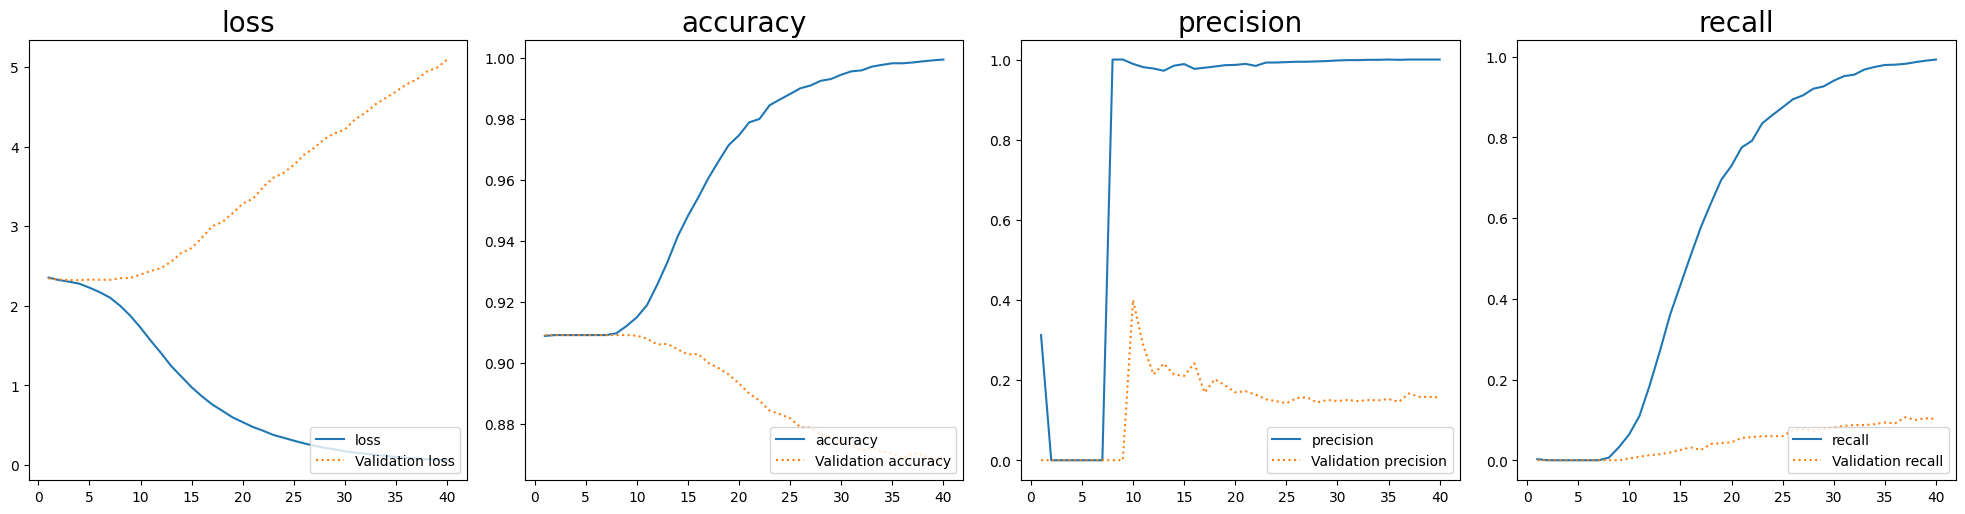

In [23]:
plot_train_val_data(hist,["loss","accuracy","precision","recall"],validation=True)

15/15 [==============================] - 0s 2ms/step


Text(50.722222222222214, 0.5, 'Truth')

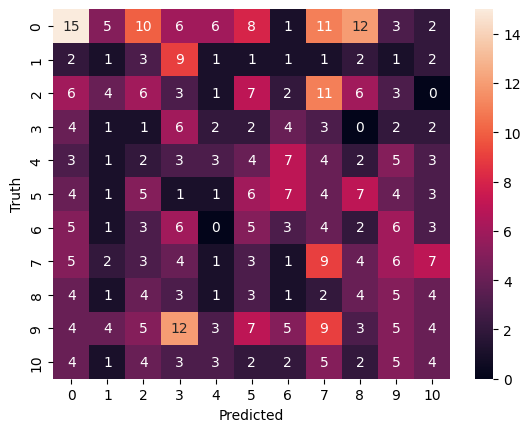

In [24]:
y_predicted = model.predict(X_test)
predicted = [np.argmax(el) for el in y_predicted]
cm = confusion_matrix(Y_test, predicted)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')